<img width="500px" style="alignment:center" src="../images/logo_dark.png">

# Workshop 2023

## Hugo Karas

Based on the work and previous workshop by Luis Fábregas Ibáñez, Gunnar Jeschke & Stefan Stoll

<img style=" alignment:center" src="../images/logo_school23.gif">

## What is DeerLab?

DeerLab is an advanced python based software for analysing DEER/PELDOR data using Tikihnov regularisation

## Getting Started

First we will look at processing a simple 4-pulse DEER trace

In [1]:
import deerlab as dl
# We all need some other packages too
import numpy as np # Numerical calculations and array handling
import matplotlib.pyplot as plt # Plotting

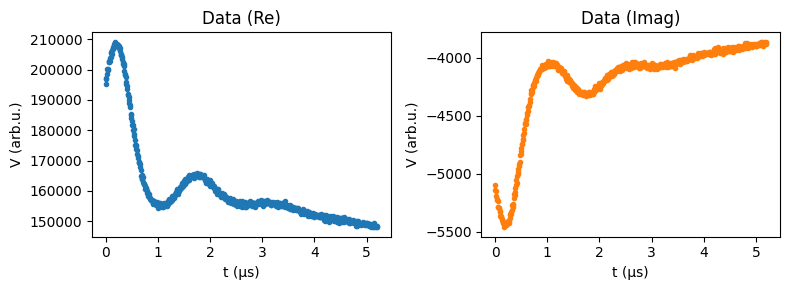

In [2]:
t,V = dl.deerload('data/example_4pdeer_4.DTA')

# Plot the data
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t,V.real,'.',label='data (real)')
plt.title('Data (Re)')
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.subplot(1,2,2)
plt.plot(t,V.imag,'.',label='data (imag)',color='C1')
plt.title('Data (Imag)')
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.tight_layout()
plt.show()

## Pre-processing Data

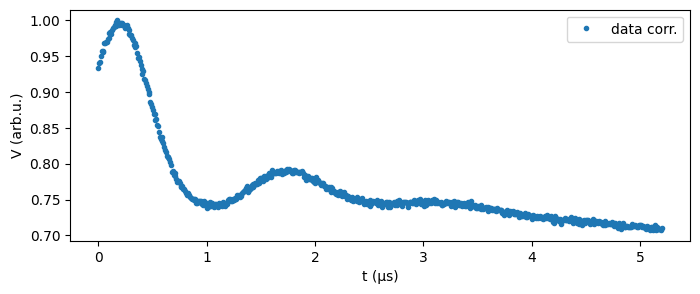

In [3]:
# Phase correction
Vexp = dl.correctphase(V)
# Normalize the data (only for plotting purposes)
Vexp = Vexp/np.max(Vexp)
plt.figure(figsize=(8,3))
plt.plot(t,Vexp,'.',label='data corr.')
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.legend()
plt.show()

### Acounting for the start time

Since DeerLab has been designed for multi-pathway data, the definition of the zero point in time is critically important

<img style="width:500px; alignment:center" src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/main/images/4pdeer_sequence_starttime.svg">

In Deerlab the *zerotime* is defined as the time of $\pi$ pulse before the moving pump pulse. Check documentation for specifics


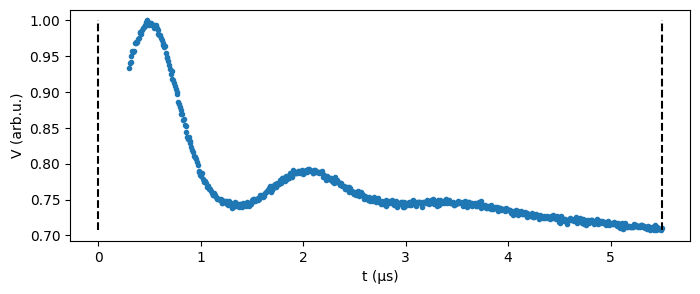

In [5]:
tau1 = 0.5 # µs
tau2 = 5.0 # µs
tmin = 0.3 # µs

t = t - t[0]  # Subtracting first value in array
t = t + tmin

plt.figure(figsize=(8,3))
plt.plot(t,Vexp,'.',label='data corr.')

plt.vlines(0,min(Vexp),max(Vexp),'k',linestyle='dashed')
plt.vlines(tau1+tau2,min(Vexp),max(Vexp),'k',linestyle='dashed')

plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.show()

## Fitting

Before we can fit out data we must first build a model.

We can build a simple dipolar model

In [8]:
# Define the distance range
r = np.linspace(2,5,100)  # nm 

# Construct the dipolar model
Vmodel = dl.dipolarmodel(t,r) 

# Display information about the dipolar model
print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Start   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======= ======== ======== ====== ====================================== 
 mod           0    0.01       1   nonlin     No            Modulation depth                      
 reftime     -20       0      20   nonlin     No      μs    Refocusing time                       
 conc       0.01      50   5e+03   nonlin     No      μM    Spin concentration                    
 P             0       0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======= ======== ======== ====== ====================================== 


<img style="alignment:center" src="../images/Experiment_models.png">


DeerLab includes a wide range of built in models which can then handle the different pathways.

- 4pDEER
- fwd5pDEER
- rev5pDEER
- RIDME

and many more...

In [9]:
# Construct model of our 4-pulse DEER experiment
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1])

# Construct the dipolar signal model including experimental information
Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) 

# Display information about the model
print(Vmodel)

Description: 4-pulse DEER dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Start   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======= ======== ======== ====== ====================================== 
 mod           0    0.01       1   nonlin     No            Modulation depth                      
 reftime   0.452     0.5   0.548   nonlin     No      μs    Refocusing time                       
 conc       0.01      50   5e+03   nonlin     No      μM    Spin concentration                    
 P             0       0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======= ======== ======== ====== ====================================== 


We can now use this model to fit our data in one go

In [10]:
results = dl.fit(Vmodel,Vexp, verbose=2, ftol=1e-3)

[1-9-2023 9:14:24] Preparing the SNLLS analysis...
[1-9-2023 9:14:24] Preparations completed.
[1-9-2023 9:14:24] Non-linear least-squares routine in progress...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4490e+00                                    1.06e+01    
       1              2         9.4994e-02      1.35e+00       1.67e+02       4.72e-01    
       2              3         2.4966e-02      7.00e-02       4.41e+01       7.89e-01    
       3              4         2.4795e-03      2.25e-02       5.51e+01       7.97e-01    
       4              5         1.7265e-03      7.53e-04       6.13e-01       1.57e-02    
       5              6         1.7258e-03      6.74e-07       7.99e-02       4.13e-04    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 1.4490e+00, final cost 1.7258e-03, first-order optimality 4.13e-04.
[1-9-2023 9:14:29] Least-squares routine finished.
[1-

In [11]:
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.002         0.999             0.023          0.002  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.145            
Model parameters: 
=========== ========= ========================= ====== ====================================== 
 Parameter   Value     95%-Confidence interval   Unit   Description                           
=========== ========= ========================= ====== ====================================== 
 mod         0.200     (0.199,0.202)                    Modulation depth                      
 reftime     0.499     (0.497,0.501)              μs    Refocusing time                       
 conc        118.862   (117.419,120.305)          μM    Spin co

## Plotting

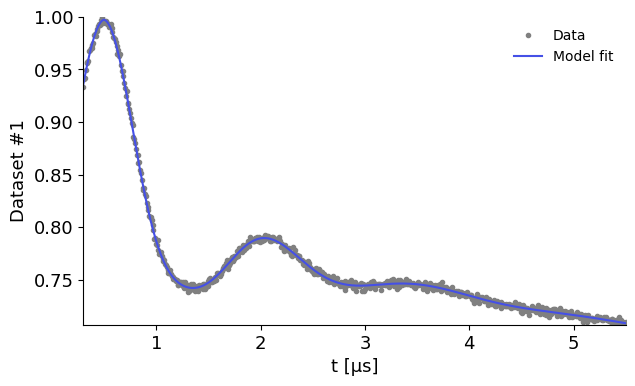

In [12]:
results.plot(axis=t,xlabel='t [μs]')

# Show the plot
plt.show() 

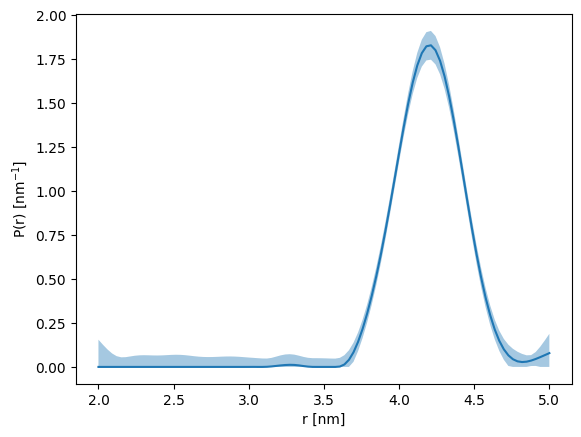

In [13]:
# Get the fitted distance distribution
Pfit = results.P
# Get the uncertainty quantification of the distance distribution
Puq = results.PUncert
# Get its 95% confidence intervals
Pci95 = Puq.ci(95)

# Get the lower/upper boundaries of the confidence intervals
Pci95_lower = Pci95[:,0]
Pci95_upper = Pci95[:,1]

# Plot the fitted distance distribution
plt.plot(r,Pfit)
# Plot the confidence bands as a filled area
plt.fill_between(r,Pci95_lower,Pci95_upper,alpha=0.4)
plt.xlabel('r [nm]')
plt.ylabel('P(r) [nm$^{-1}$]')
plt.show()

In [14]:
mod_fit = results.mod
mod_ci95 = results.modUncert.ci(95)

# Spin concentration
conc_fit = results.conc
conc_ci95 = results.concUncert.ci(95)


print(f'Modulation depth: {mod_fit:.3f} ({mod_ci95[0]:.3f},{mod_ci95[1]:.3f})')
print(f'Spin concentration: {conc_fit:.4g}uM ({conc_ci95[0]:.4g},{conc_ci95[1]:.4g})')

Modulation depth: 0.200 (0.199,0.202)
Spin concentration: 118.9uM (117.4,120.3)


In [15]:
stats = dl.diststats(r,Pfit,Puq,verbose=True)

-------------------------------------------------
Distribution Statistics
-------------------------------------------------
Range                    2.00-5.00 nm
Integral                 1.00
-------------------------------------------------
Location
-------------------------------------------------
Range                    2.00-5.00 nm
Mean                     4.20 (4.19,4.22) nm
Median                   4.20 (4.20,4.21) nm
Interquartile mean       4.20 (4.20,4.20) nm
Mode                     4.21 nm
-------------------------------------------------
Spread
-------------------------------------------------
Standard deviation       0.22 (0.14,0.30) nm
Mean absolute deviation  0.17 (0.16,0.19) nm
Interquartile range      0.29 (0.29,0.30) nm
Variance                 0.05 (0.01,0.08) nm²
-------------------------------------------------
Shape
-------------------------------------------------
Modality                 1
Skewness                 0.12 (-8.31,8.55) 
Kurtosis                 -0.

## Dipolar Pathway Theory

<img src="../images/4pdeer_example.svg" alt="drawing" style="width:400px; margin:auto; display:block; "/>

In reality it is rare that every pulse is perfect, and spins do not flip perfectly. This can result in a dipolar pathway that refocuses at a different time. DeerLab is able to fit a multi-pathway model.

The "2+1" artifact is show as pathway 2. If you get pathway you nearly always have pathway 3 so you **must** use a multi-pathway model not just cut the data.

For more infomation on pathway theory checkout Luis's PCCP paper. DOI: 10.1039/D1CP03305K

### Now lets give this a go with some real data

Compared to our previous method we only have to change 1 line:
```python
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1,2,3])

```

Our model will now look a little different:
```
Description: 4-pulse DEER dipolar signal model
Signature: (lam1, reftime1, lam2, reftime2, lam3, reftime3, conc, P)
Constants: []
Parameter Table: 
========== ======== ======= ======= ======== ======== ====== ====================================== 
 Name       Lower    Start   Upper    Type    Frozen   Unit   Description                           
========== ======== ======= ======= ======== ======== ====== ====================================== 
 lam1           0     0.01       1   nonlin     No            Amplitude of pathway #1               
 reftime1   0.452      0.5   0.548   nonlin     No      μs    Refocusing time of pathway #1         
 lam2           0     0.01       1   nonlin     No            Amplitude of pathway #2               
 reftime2    5.45      5.5    5.55   nonlin     No      μs    Refocusing time of pathway #2         
 lam3           0     0.01       1   nonlin     No            Amplitude of pathway #3               
 reftime3   -0.048       0   0.048   nonlin     No      μs    Refocusing time of pathway #3         
 conc        0.01       50   5e+03   nonlin     No      μM    Spin concentration                    
 P              0        0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========== ======== ======= ======= ======== ======== ====== ====================================== 
```
We no longer have a `mod` parameter. Instead we have three `lamx`. These together form your *modulation depth*.

### Your turn now

The file is located at `"data/Exercise1.DTA"`
```python
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1,2,3])

```

$\tau_1 = 0.4 \mu s$

$\tau_2 = 4.2 \mu s$

$t_{min} = 0.28 \mu s$



#### Solution

In [19]:
t,V = dl.deerload('data/Exercise1.DTA')
Vexp = dl.correctphase(V) # Phase correction
Vexp = Vexp/np.max(Vexp)  # Normalize the data (only for plotting purposes)
tau1 = 0.4 # µs
tau2 = 4.2 # µs
tmin = 0.28 # µs

t = t -t[0]
t = t + tmin

r = np.linspace(1.5,6,100) # range from 2.2-5.2nm with 0.02nm resolution

Vmodel = dl.dipolarmodel(t,r) # Construct the dipolar model


my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1,2,3])

Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) # Construct the dipolar signal model including experimental information

results = dl.fit(Vmodel,Vexp, ftol=1e-3)
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.009         1.093             0.020          0.010  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          1.344            
Model parameters: 
=========== ======== ========================= ====== ====================================== 
 Parameter   Value    95%-Confidence interval   Unit   Description                           
=========== ======== ========================= ====== ====================================== 
 lam1        0.375    (0.297,0.454)                    Amplitude of pathway #1               
 reftime1    0.414    (0.383,0.445)              μs    Refocusing time of pathway #1         
 lam2        0.073    (0.046,0.100)                    Amplitude of 

In [20]:
Vfit = results.model
Vci95 = results.propagate(Vmodel).ci(95)

Pfit = results.P # Get the fitted distance distribution
Puq = results.PUncert # Get the uncertainty quantification of the distance distribution

Pci95 = Puq.ci(95) # Get its 95% confidence intervals


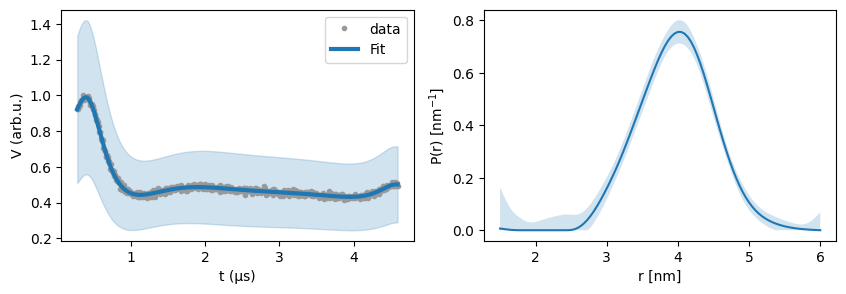

In [21]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.plot(t,Vexp,'.',label='data',color='0.6')
plt.plot(t,Vfit,linewidth=3,color='C0',label='Fit')
plt.fill_between(t,Vci95[:,0],Vci95[:,1],alpha=0.2,color='C0')

plt.legend()
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')


plt.subplot(1,2,2)

# Plot the fitted distance distribution
plt.plot(r,Pfit)
# Plot the confidence bands as a filled area
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.2)
plt.xlabel('r [nm]')
plt.ylabel('P(r) [nm$^{-1}$]')
plt.show()

## Getting Help

Detailed documentation can be found at: [jeschkelab.github.io/DeerLab](jeschkelab.github.io/DeerLab)

### Looking at the examples

<img src="../images/Examples.png">

### Asking Others
Post questions and queries on the discuisson board: 
<img src="../images/Discussion_Board.png">

### Reporting Issues:
Help the development team buy requesting new features and reporting bugs on

GitHub. We can't fix an issue or implement a new feature if we don't know it exists.
<img src="../images/Issues_Board.png">